# Importing

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics.pairwise import cosine_similarity

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
# import tensorflow_addons as tfa
from keras.utils import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from keras import Sequential, Input
#from keras.utils import to_categorical
from keras.utils import to_categorical
from keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Conv2D, Flatten
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator as IDG

import librosa
import librosa.display
import IPython.display as ipd

import eli5
from eli5.sklearn import PermutationImportance

import joblib

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
#dir_ = '../input/gtzan-dataset-music-genre-classification/Data'
dir_ = 'Data'
print(list(os.listdir(f'{dir_}/genres_original/')))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
y, s = librosa.load(f'{dir_}/genres_original/blues/blues.00023.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', s, '\n')

print('Check Len of Audio:', 661794/22050)

y: [ 0.17184448  0.20730591  0.08227539 ...  0.00271606 -0.02062988
 -0.01370239] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [5]:
audio, _ = librosa.effects.trim(y)

print('Audio File:', audio, '\n')
print('Audio File shape:', np.shape(audio))

Audio File: [ 0.17184448  0.20730591  0.08227539 ...  0.00271606 -0.02062988
 -0.01370239] 

Audio File shape: (661794,)


# EDA

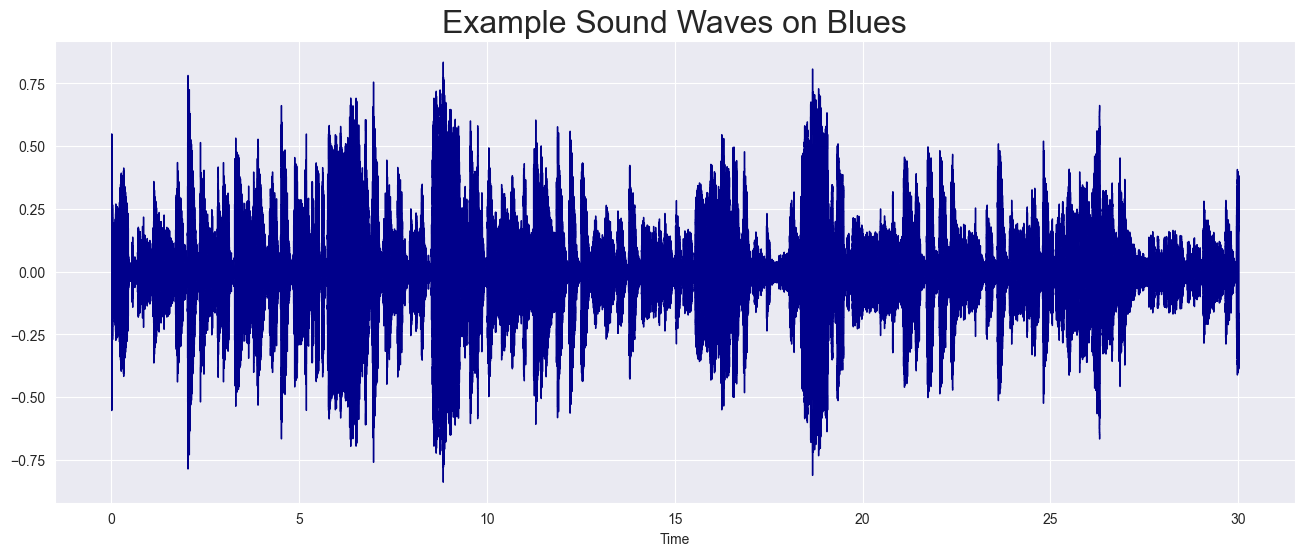

In [6]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = s, color = "#00008B");
plt.title("Example Sound Waves on Blues", fontsize = 23);

In [7]:
#Fourier Transform

fft = 2048
hl = 512

stft = np.abs(librosa.stft(audio, n_fft = fft, hop_length = hl))

print(np.shape(stft))

(1025, 1293)


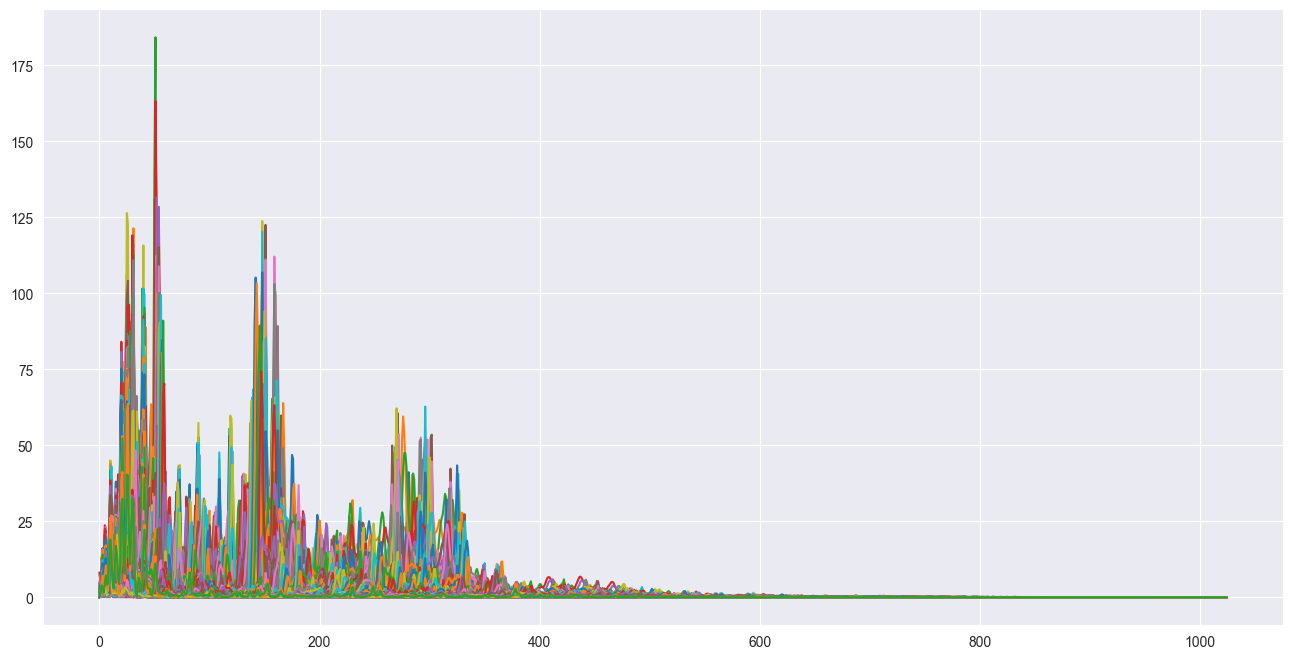

In [8]:
plt.figure(figsize = (16, 8))
plt.plot(stft);

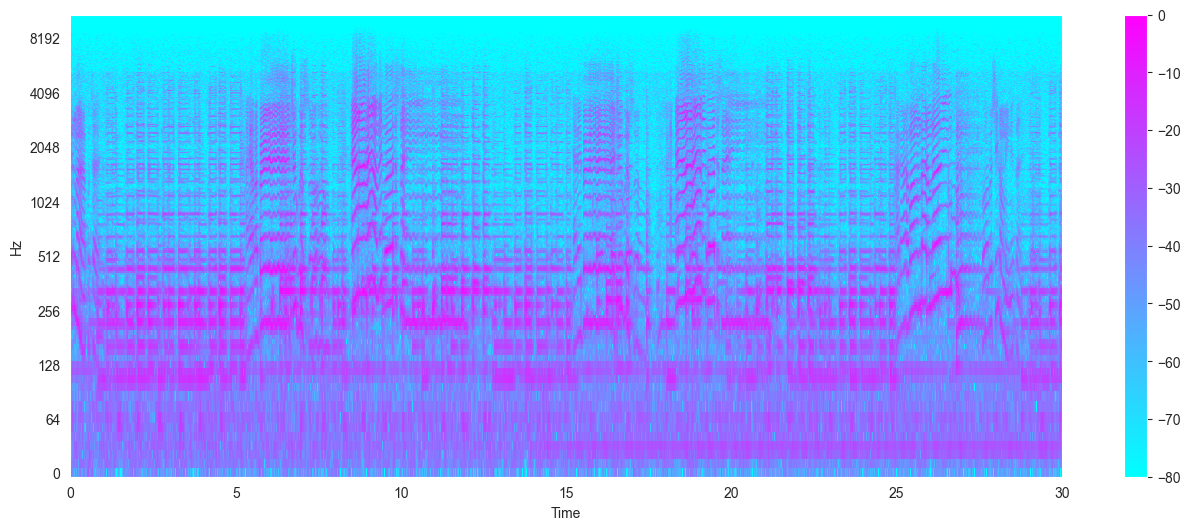

In [9]:
decibel = librosa.amplitude_to_db(stft, ref = np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(decibel, sr = s, hop_length = hl, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

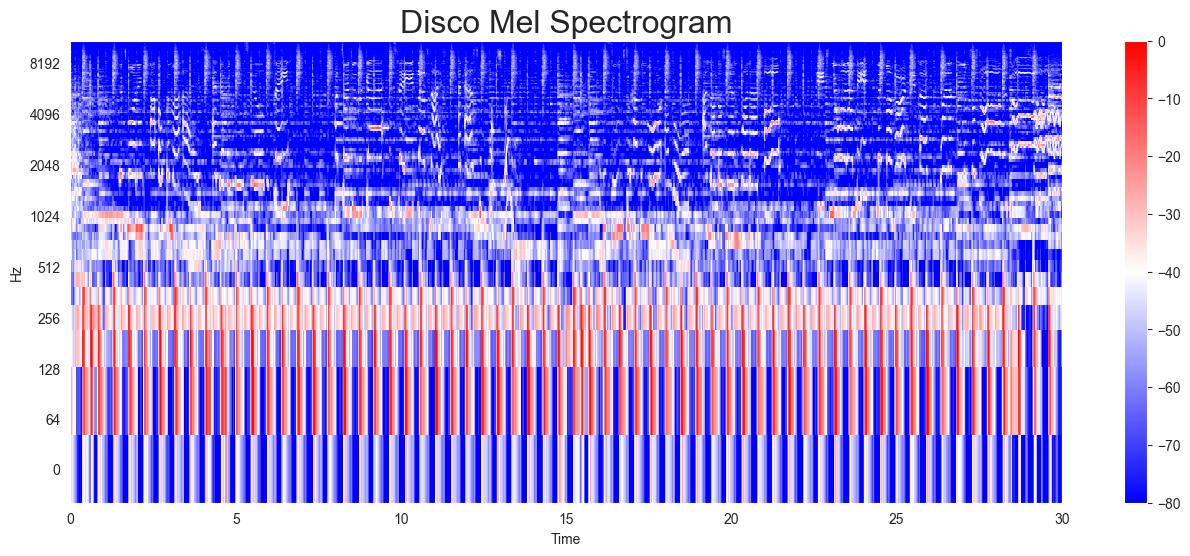

In [10]:
y, s = librosa.load(f'{dir_}/genres_original/disco/disco.00007.wav')
y, z = librosa.effects.trim(y)


mel = librosa.feature.melspectrogram(y=y, sr=s)
mel_db = librosa.amplitude_to_db(mel, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(mel_db, sr=s, hop_length=hl, x_axis = 'time', y_axis = 'log',
                        cmap = 'bwr');
plt.colorbar();
plt.title("Disco Mel Spectrogram", fontsize = 23);

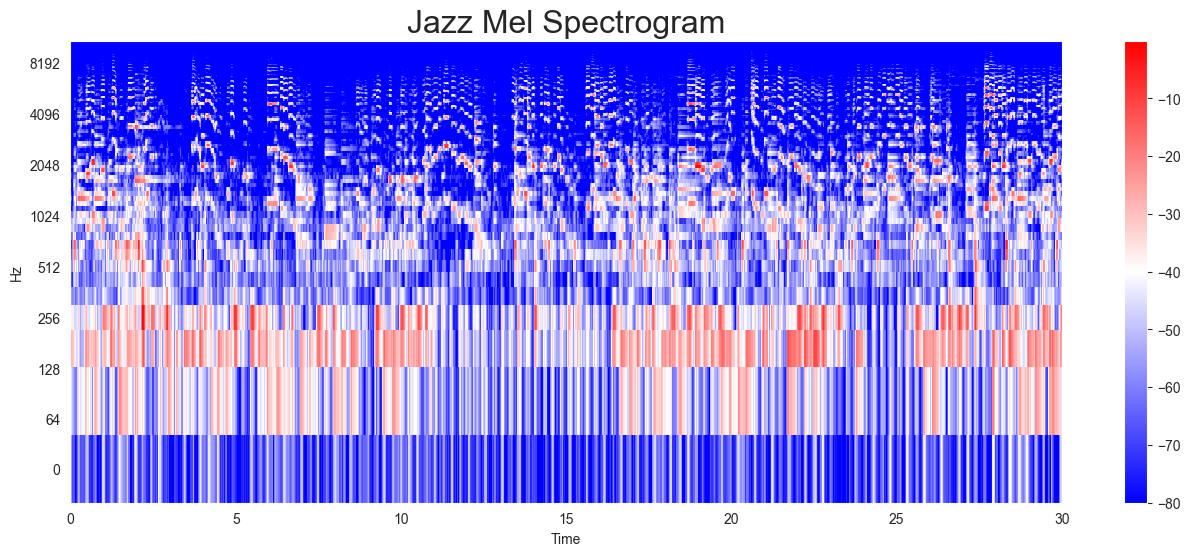

In [11]:
y, s = librosa.load(f'{dir_}/genres_original/jazz/jazz.00015.wav')
y, z = librosa.effects.trim(y)


mel = librosa.feature.melspectrogram(y=y, sr=s)
mel_db = librosa.amplitude_to_db(mel, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(mel_db, sr=s, hop_length=hl, x_axis = 'time', y_axis = 'log',
                        cmap = 'bwr');
plt.colorbar();
plt.title("Jazz Mel Spectrogram", fontsize = 23);

In [12]:
zero_cross = librosa.zero_crossings(audio, pad=False)
print(sum(zero_cross))

34769


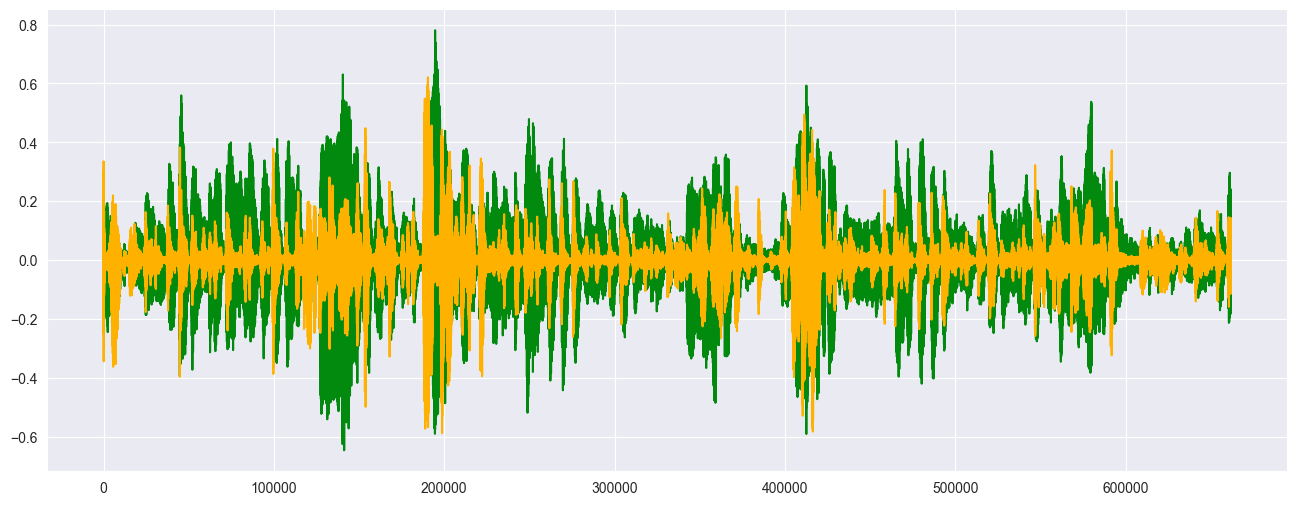

In [13]:
y_harm, y_perc = librosa.effects.hpss(audio)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#028A0F');
plt.plot(y_perc, color = '#FFB100');

In [14]:
tempo, _ = librosa.beat.beat_track(y=y, sr = s)
tempo

117.45383522727273

In [15]:
sc = librosa.feature.spectral_centroid(y=audio, sr=s)[0]

print('Centroids:', sc, '\n')
print('Shape of Spectral Centroids:', sc.shape, '\n')

frames = range(len(sc))

t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1445.25434511 1363.15233037 1272.39183755 ...  937.47853521  928.49295186
  913.51640189] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


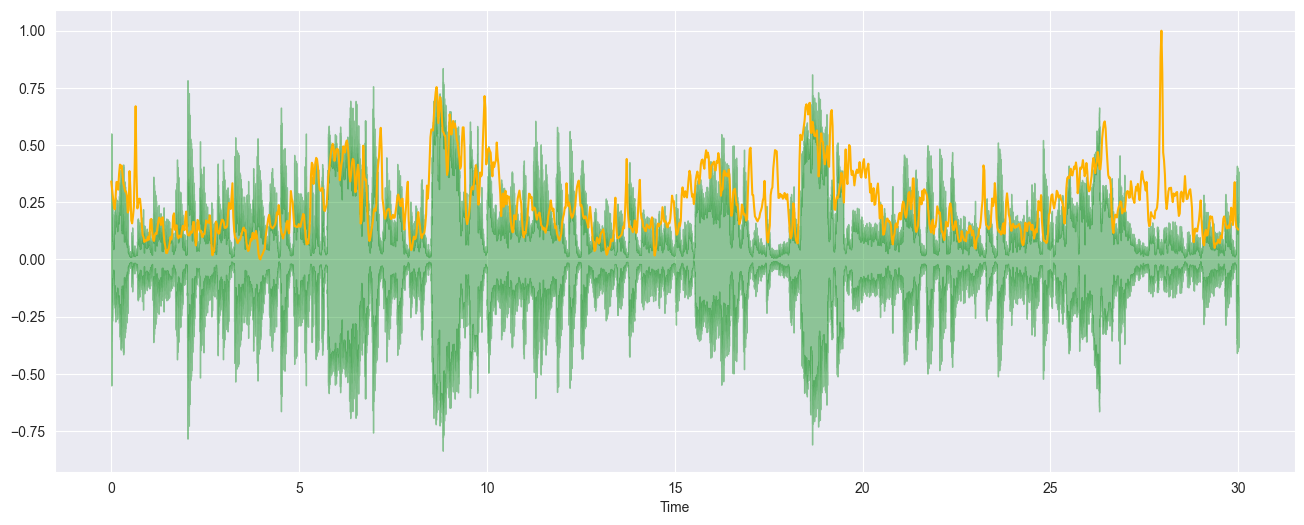

In [16]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio, sr=s, alpha=0.4, color = '#028A0F');
plt.plot(t, normalize(sc), color='#FFB100');

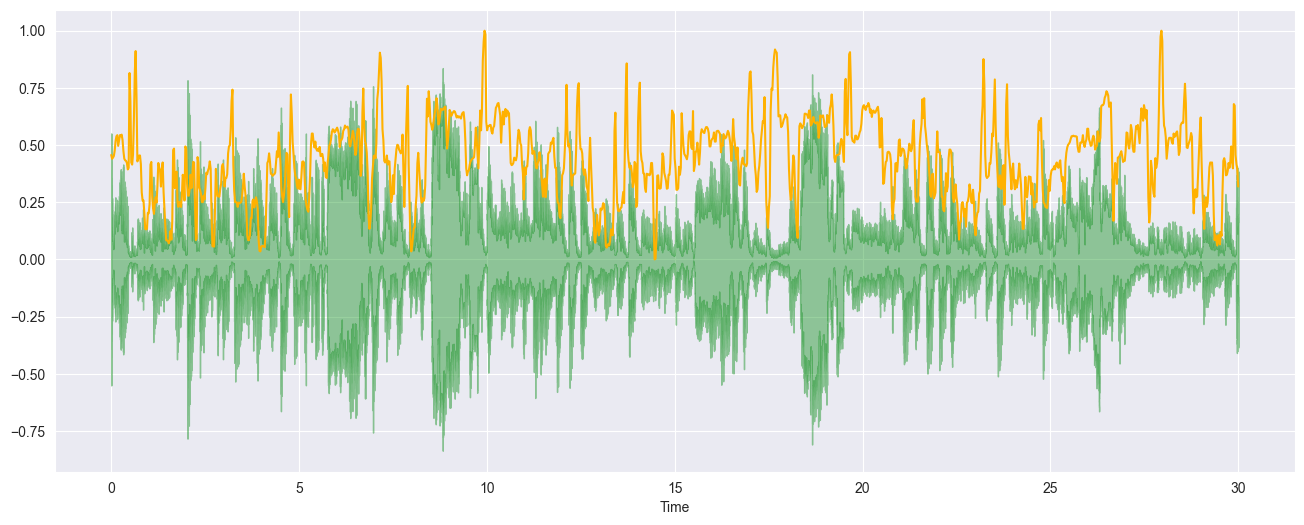

In [17]:
sr = librosa.feature.spectral_rolloff(y=audio, sr=s)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio, sr=s, alpha=0.4, color = '#028A0F');
plt.plot(t, normalize(sr), color='#FFB100');

(20, 1293)


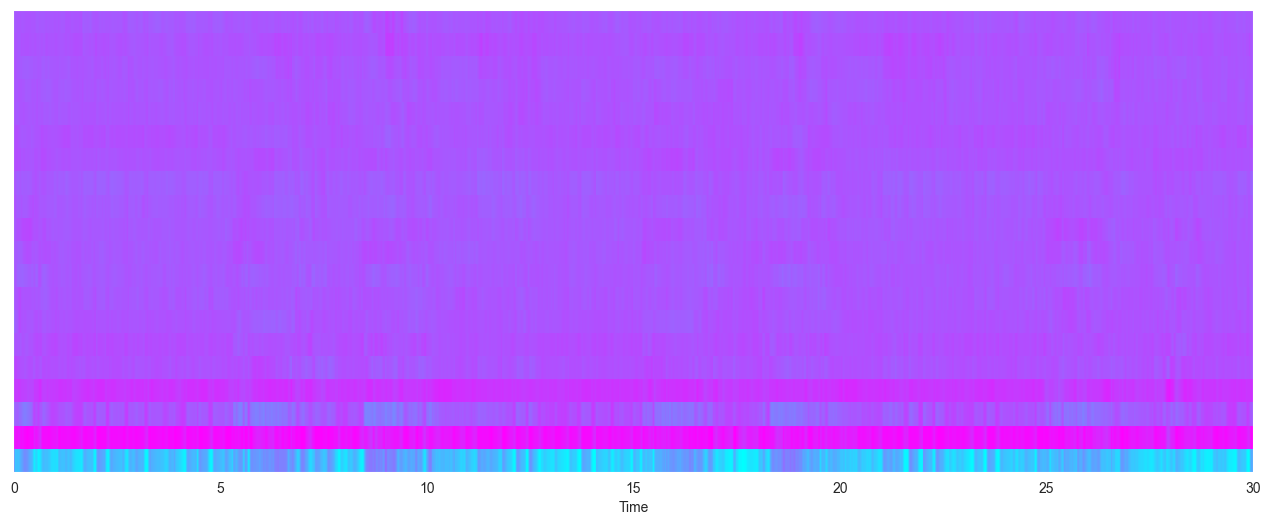

In [18]:
mfcc = librosa.feature.mfcc(y=audio, sr=s)
print(mfcc.shape)

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfcc, sr=s, x_axis='time', cmap = 'cool');

Mean: -2.2127014e-09 

Var: 1.0


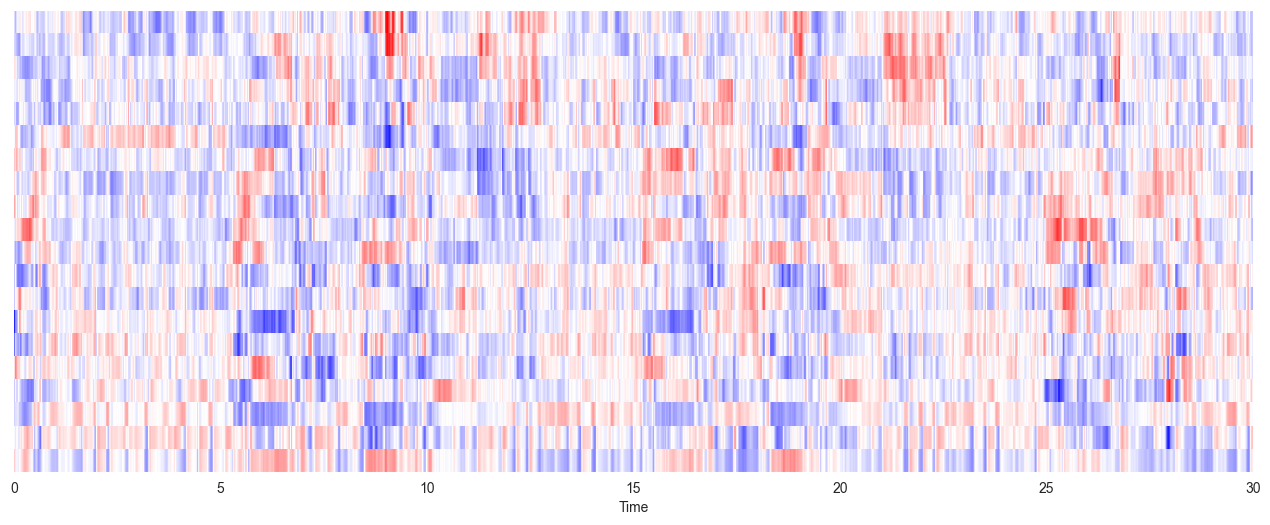

In [19]:
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
print('Mean:', mfcc.mean(), '\n')
print('Var:', mfcc.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfcc, sr=s, x_axis='time', cmap = 'bwr');

Chromogram shape: (12, 133)


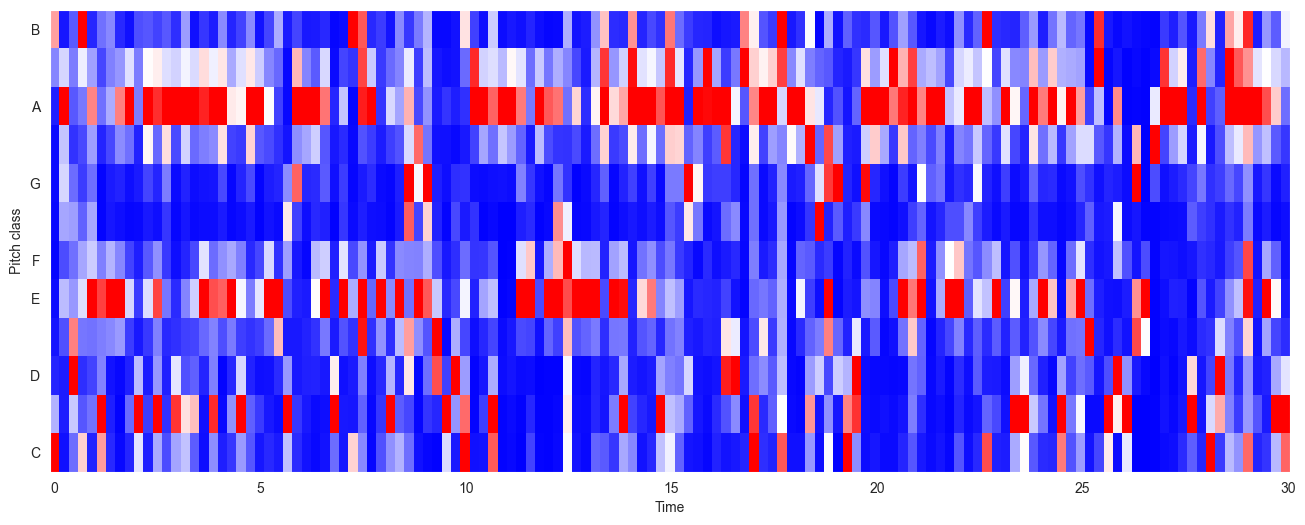

In [20]:
hl = 5000

#
chromagram = librosa.feature.chroma_stft(y=audio, sr=s, hop_length=hl)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hl, cmap='bwr');

In [21]:
df = pd.read_csv(f'{dir_}/features_30_sec.csv')
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


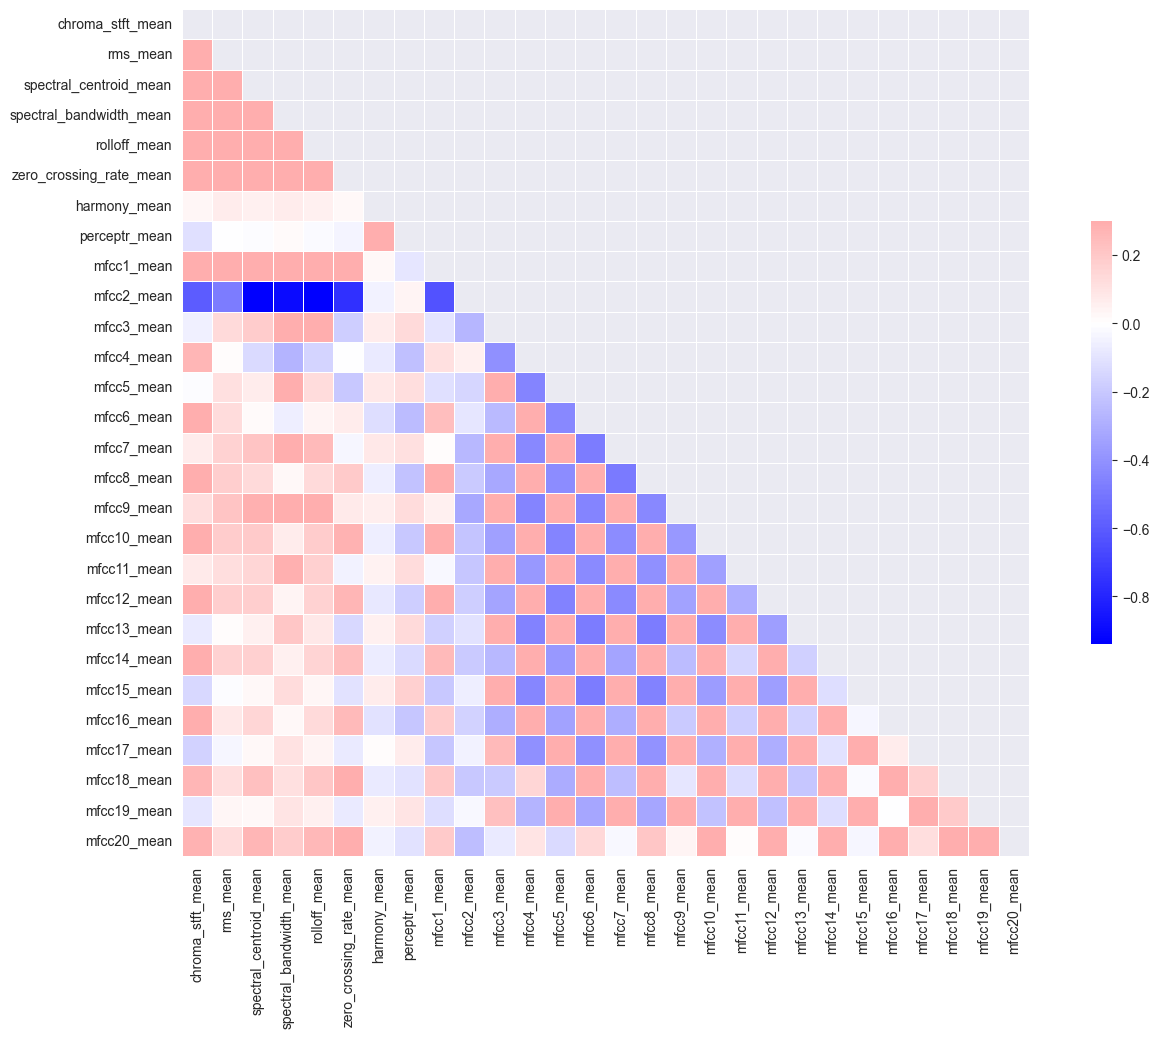

In [22]:
spike = [col for col in df.columns if 'mean' in col]
corr = df[spike].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16, 11));

sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

Text(0, 0.5, 'BPM')

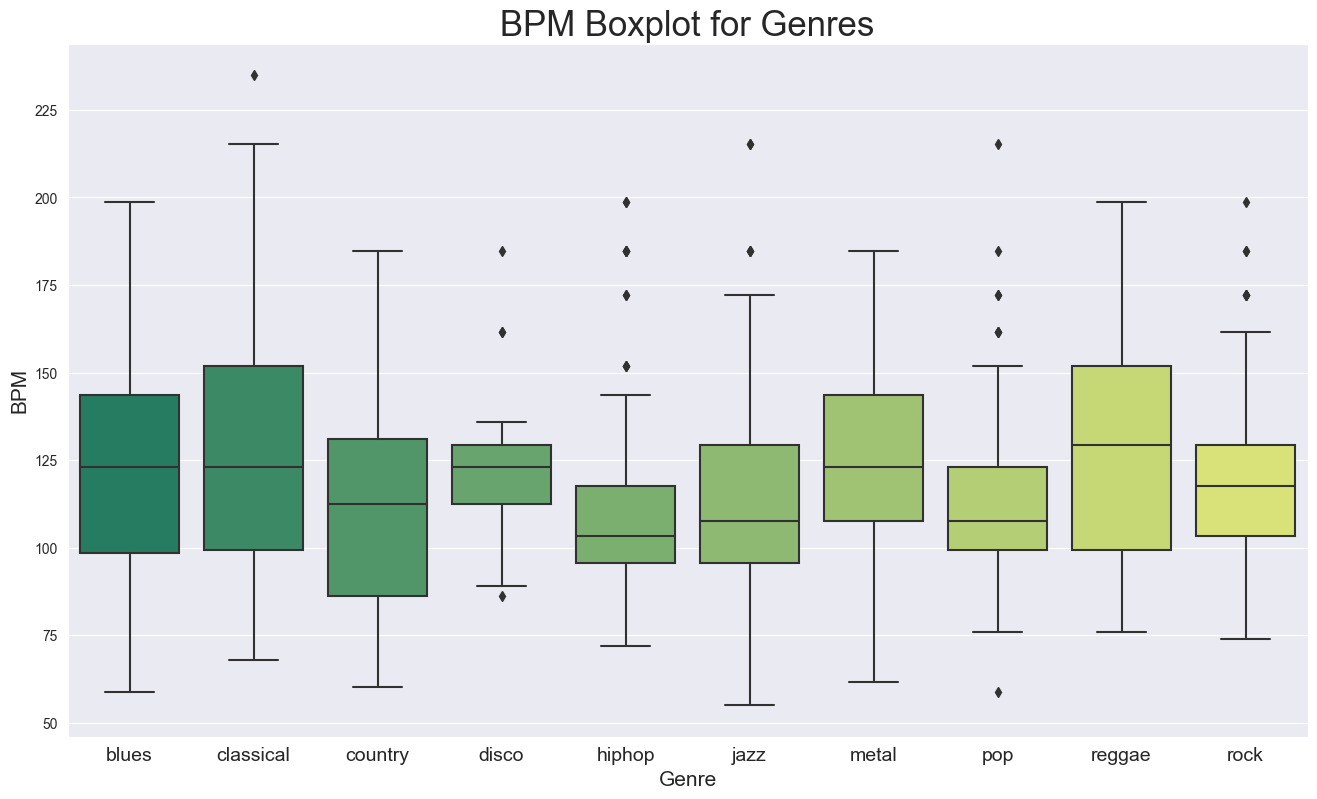

In [23]:
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'summer');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

# Scaling

In [24]:
df = df.iloc[0:, 1:]
y = df['label']
X = df.loc[:, df.columns != 'label']

cols = X.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

pca = PCA(n_components=2)
scaled_df = pca.fit_transform(X)
df_p = pd.DataFrame(data = scaled_df, columns = ['pca1', 'pca2'])

fdf = pd.concat([df_p, y], axis = 1)

pca.explained_variance_ratio_

array([0.2439355 , 0.21781804])

Text(0, 0.5, 'Principal Component 2')

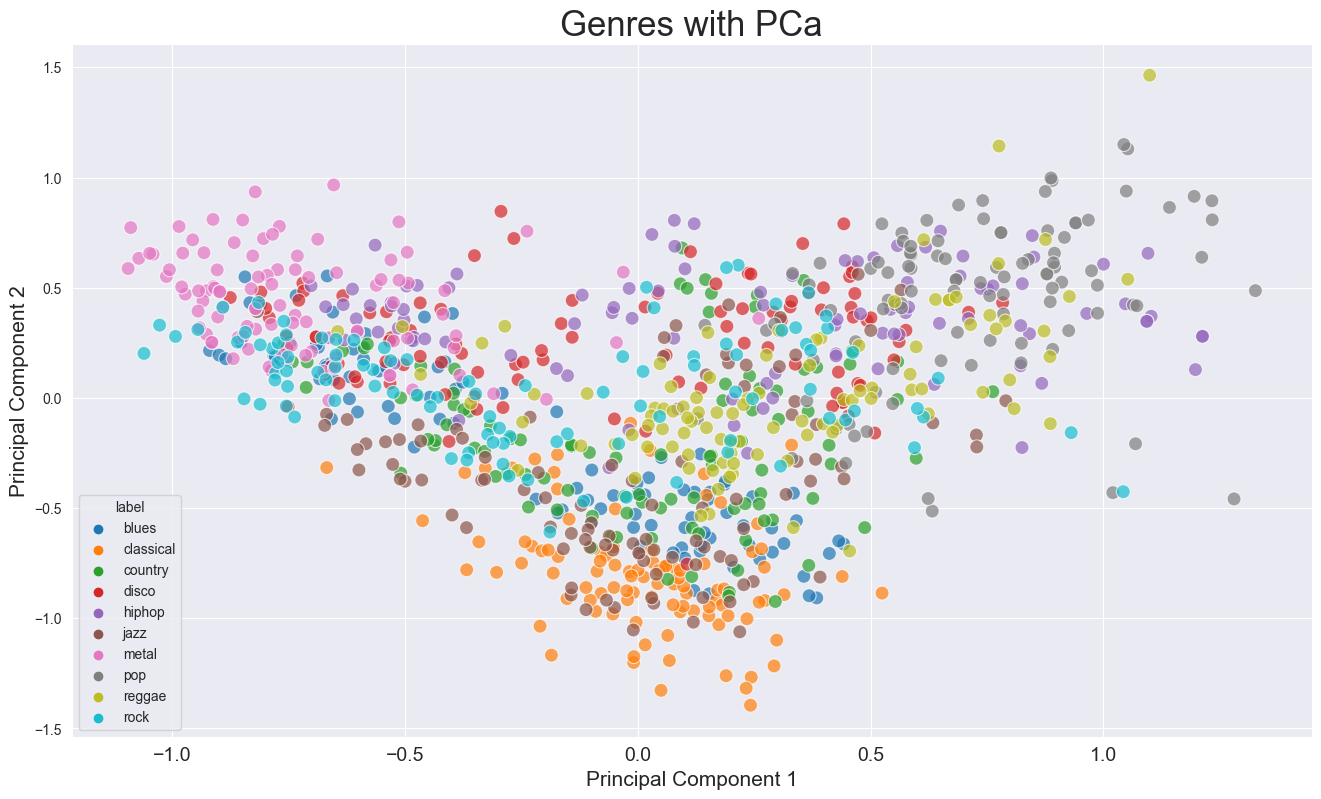

In [25]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pca1", y = "pca2", data = fdf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('Genres with PCa', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

# Modeling

In [26]:
df = pd.read_csv(f'{dir_}/features_3_sec.csv')
df = df.iloc[0:, 1:] 
df

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [27]:
y = df['label']
X = df.loc[:, df.columns != 'label']

cols = X.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_test['mfcc2_var']

4022    0.146313
5412    0.021698
487     0.053309
39      0.041629
6795    0.024097
          ...   
1579    0.006917
7905    0.046853
6113    0.011733
3532    0.141974
409     0.033834
Name: mfcc2_var, Length: 2997, dtype: float64

In [29]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [30]:
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

ada = AdaBoostClassifier(n_estimators=1000)
model_assess(ada, "AdaBoost")

[[100   6  61  12   1  19  85   0  12  23]
 [  0 275   1   0   0  21   0   0   1  10]
 [ 20  11 166  25   4   8  22  11  10   9]
 [ 13   4  30 102  13   2  57  46  17  17]
 [  8   1  15  36 109   0  44  60  36   2]
 [ 10  59  34   6   0 117   8  13   5  34]
 [  5   0   3  11   3   0 269   0   3   9]
 [  0   0  17  18   2   1   0 208  13   8]
 [ 19   1  61  10  23   3   6  29 149  15]
 [  8   6  49  40   2   7  96  13  17  62]]
Accuracy Naive Bayes : 0.51952 

[[257   9   9   3   8  15  12   0   6   0]
 [  1 302   3   0   0   2   0   0   0   0]
 [ 51   7 150  12   7  29   0  13  13   4]
 [ 15  10  19 145  62   7   2  25  14   2]
 [ 15   5   8   2 237   0   6  15  21   2]
 [ 17  48   6   1   2 203   0   2   7   0]
 [ 32   1   5  13  12   0 231   0   5   4]
 [  1   2   7   4  19   4   0 221   7   2]
 [ 21   2  15   8  61   7   3   4 192   3]
 [ 76  13  30  46  25  29  11  14  30  26]]
Accuracy Stochastic Gradient Descent : 0.65532 

[[256   5  22   4   2   8   6   0  10   6]
 [  0 297   1

KeyboardInterrupt: 

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

joblib.dump(rf, "./saved-model/2023-6-4-17-30.pkl")

preds = rf.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

conf = confusion_matrix(y_test, preds)

plt.figure(figsize = (16, 9))
sns.heatmap(conf, cmap="bwr", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);

In [ ]:
perm = PermutationImportance(estimator=rf, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

In [ ]:
df = pd.read_csv(f'{dir_}/features_30_sec.csv', index_col='filename')

labels = df[['label']]

df = df.drop(columns=['length','label'])
df

scaled=preprocessing.scale(df)
print('Scaled data type:', type(scaled))

In [ ]:
similarity = cosine_similarity(scaled)
print("Similarity shape:", similarity.shape)

sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names

In [ ]:
def find_similar_songs(name):
    series = sim_df_names[name].sort_values(ascending = False)
    series = series.drop(name)
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

In [ ]:
find_similar_songs('rock.00011.wav') 

ipd.Audio(f'{dir_}/genres_original/rock/rock.00011.wav')

In [ ]:
ipd.Audio(f'{dir_}/genres_original/country/country.00054.wav')

In [ ]:
ipd.Audio(f'{dir_}/genres_original/jazz/jazz.00095.wav')